# Introduction
In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City. There are quite a few EDA kernels and some of them are excellent. Here I try to focus more on the feature extraction.


* My main goal is to craft the best possible feature set for XGB with the given Kernel environment. *

My current best submission is still based on this script. My best single model with these features reached LB 0.385. My current best LB score (0.380) is a simple model average of my two best submissions. Please feel free to fork and use the features and search better parameters.

With this simple notebook we
* Explore the dataset
* Extract 42 useful features
* Create simple 80-20 train - validation set
* Train XGBregressor
* Score test set and submit

References
* I used a few feature extraction ideas from Nir Maldin's Kernel
* https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385

# Introduction（中）
* 目标: 对XGB最好的特征。
* 脚本：
    1. EDA
    2. 42特征
    3. 80-20 train-val-split
    4. XGB Regressor
    5. Submission

# Import

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Load Data

In [2]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')
print('We have {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


# Data Descriptioiin

Let's check the data files! According the data description we should find the following columns:

|字段名|说明|说明(中)|
|:--|:--|:--|
|id|a unique identifier for each trip|id|
|vendor_id|a code indicating the provider associated with the trip record|数据提供商|
|pickup_datetime|date and time when the meter was engaged|起步时间|
|dropoff_datetime|date and time when the meter was disengaged|到达时间|
|passenger_count|the number of passengers in the vehicle (driver entered value)|乘客数(司机提供)|
|pickup_longitude|the longitude where the meter was engaged|起步经度|
|pickup_latitude|the latitude where the meter was engaged|起步纬度|
|dropoff_longitude|the longitude where the meter was disengaged|到达经度|
|dropoff_latitude|the latitude where the meter was disengaged|到达纬度|
|store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before|?|

sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
trip_duration - duration of the trip in seconds
Obviously dropoff_datetime and trip_duration are only available for the train set.

# Data Transform

In [3]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0:
    print('Trip_duration and datetimes are ok.')
else:
    print('Ooops.')

Trip_duration and datetimes are ok.


# EDA(Trip Duration)

We can see that the max trip_duration is ~ 1000 hours. Fortunately the evaluation metric is RMSLE and not RMSE . Outliers will cause less trouble. We could logtransform our target label and use RMSE during training.

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64


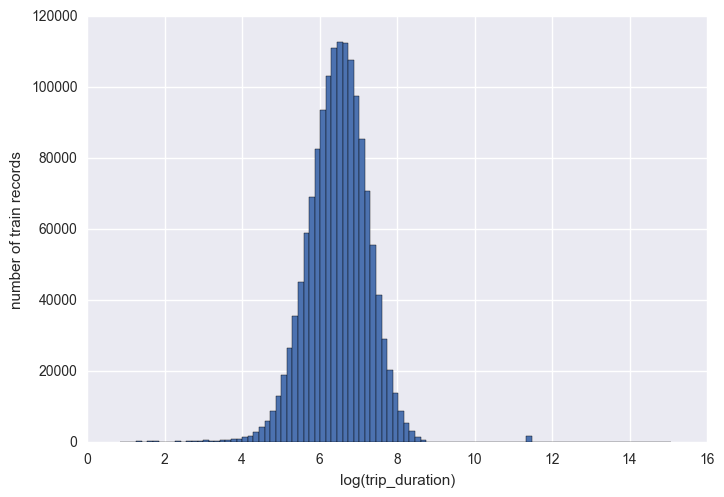

In [4]:
print train['trip_duration'].describe()
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

# EDA(Check Train Test Split)
First let's check the train test split. It helps to decide our validation strategy and gives ideas about feature engineering.

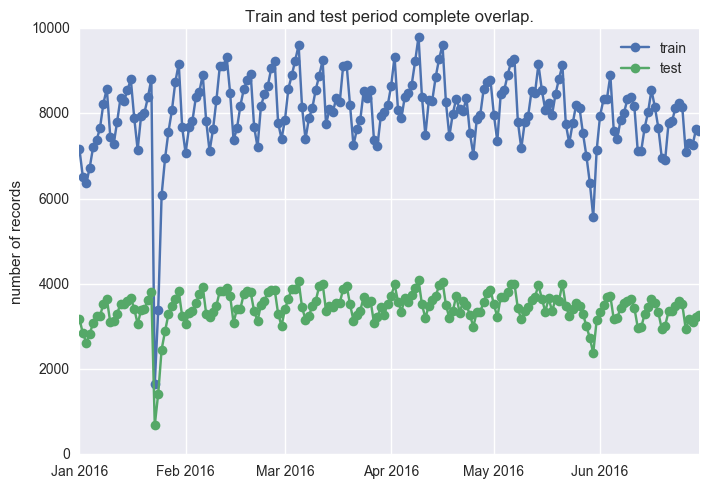

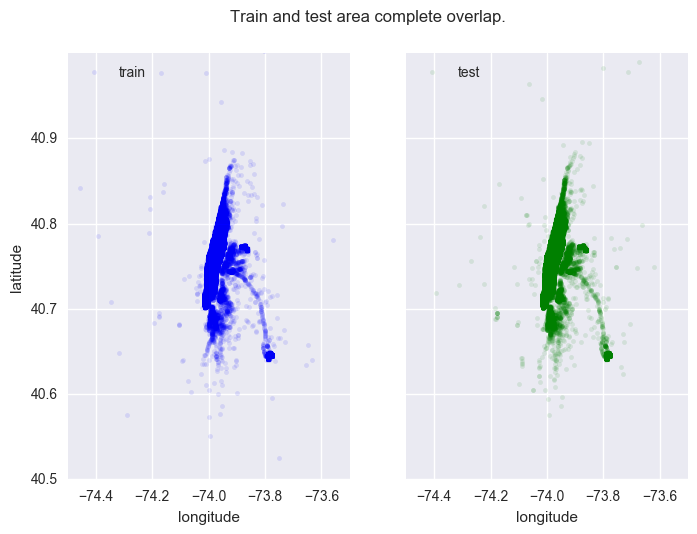

In [6]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].plot(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], 'b.',
           label='train', alpha=0.1)
ax[1].plot(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], 'g.',
           label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim([40.5, 41])
plt.xlim([-74.5, -73.5])
plt.show()

# Feature Extraction(Location PCA)

In [5]:
full = pd.concat([train, test])
coords = np.vstack((full[['pickup_latitude', 'pickup_longitude']], 
                   full[['dropoff_latitude', 'dropoff_longitude']]))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

# Feature Extraction(Distance)
Let's calculate the distance (km) between pickup and dropoff points. Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer. The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :)
pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays. We extraxt the middle of the path as a feature as well.

* 怎么算曼哈顿距离的？街道平行于经线和纬线？

In [6]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def azimuth_array(lat1, lng1, lat2, lng2):
    x = np.sin(lng2 - lng1) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng2 - lng1)
    return - np.arctan2(x, y) / np.pi * 180. % 360

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])
train.loc[:, 'azimuth'] = azimuth_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])
test.loc[:, 'azimuth'] = azimuth_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

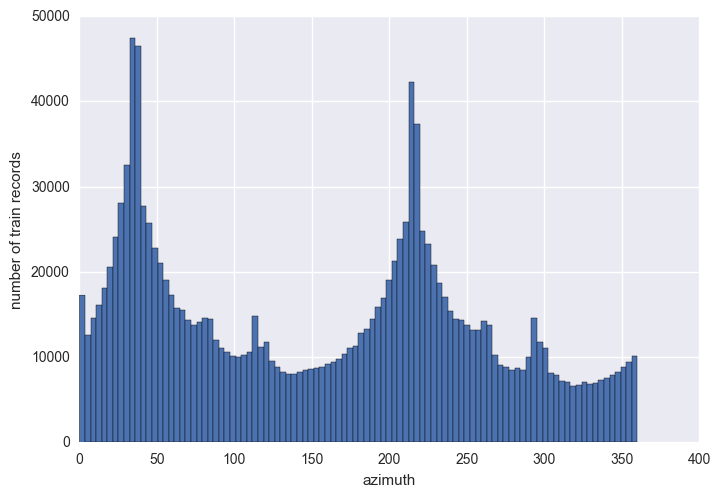

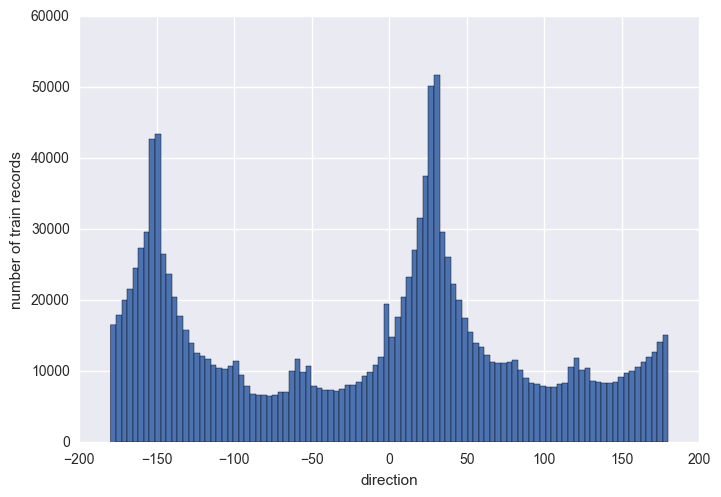

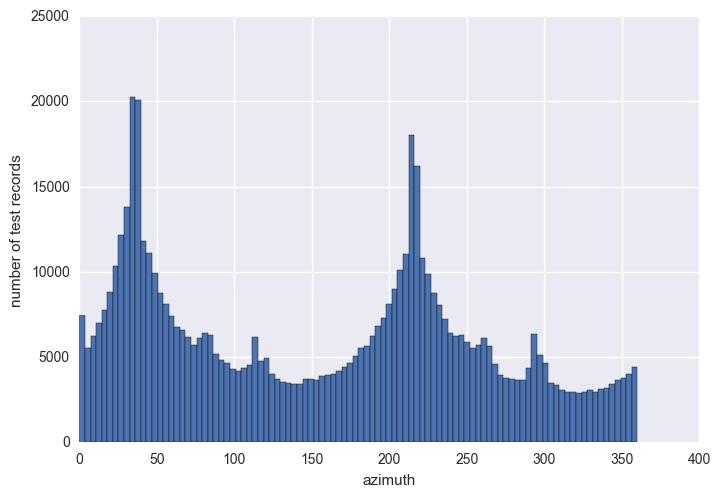

In [21]:
plt.hist(train['azimuth'].values, bins=100)
plt.xlabel('azimuth')
plt.ylabel('number of train records')
plt.show()

plt.hist(train['direction'].values, bins=100)
plt.xlabel('direction')
plt.ylabel('number of train records')
plt.show()

plt.hist(test['azimuth'].values, bins=100)
plt.xlabel('azimuth')
plt.ylabel('number of test records')
plt.show()

# Feature Extraction(Time)

In [7]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

# Feature Extraction(Speed)

1. 从目标变量构造的特征可以用么？
2. 为啥去除id不足100的？

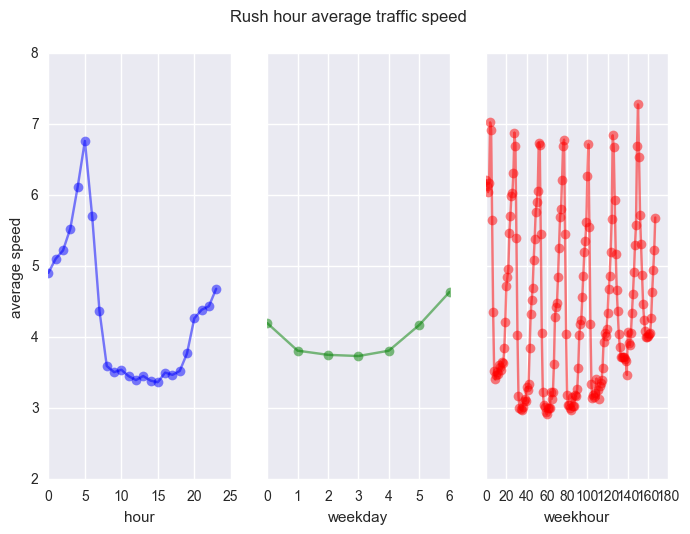

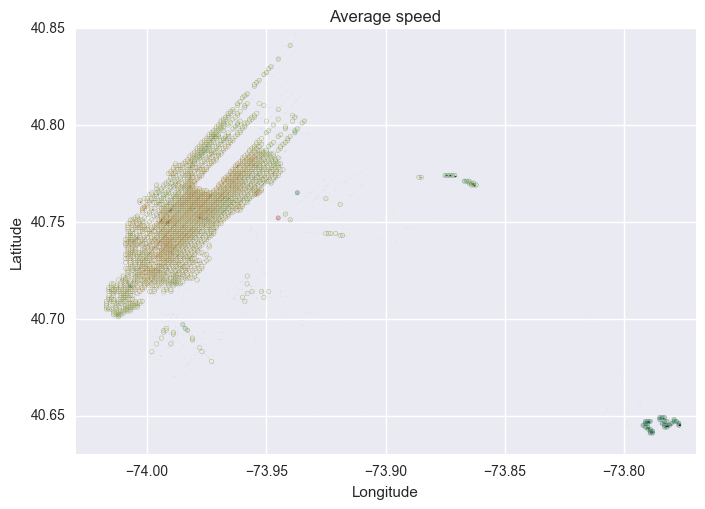

In [8]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', alpha=0.5)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-',  alpha=0.5)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-',  alpha=0.5)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)

coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], color='black', s=0.02, alpha=0.05)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=10, alpha=0.3, vmin=0, vmax=8)
ax.set_xlim(-74.03, -73.77)
ax.set_ylim(40.63, 40.85)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig('coords.png', figsize=(16, 10), dpi=300)
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

#  Feature Extraction(Temporal and geospatial aggregation)
Add a few average traffic speed features. Note that if the train/test split would be time based then we could not use as much temporal features. In this competition we do not need to predict the future.

In [9]:
for gby_col in ['pickup_hour', 'pickup_date', 'pickup_weekday', 'pickup_dt_bin',
               'pickup_week_hour']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin']] :
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

# Feature Extraction(Merge)

In [10]:
feature_names = list(train.columns)
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'azimuth']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

We have 42 features.
Feature extraction time: 111 seconds


In [12]:
train.to_csv('../input/train-380.csv', index=False)
test.to_csv('../input/test-380.csv', index=False)

# XGB(Train Test)

## Default

* [0]	train-rmse:4.22636	valid-rmse:4.22755
* Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

* Will train until valid-rmse hasn't improved in 50 rounds.
* [20]    train-rmse:0.384061 valid-rmse:0.398702
* [40]    train-rmse:0.372246 valid-rmse:0.392694
* [60]    train-rmse:0.3668   valid-rmse:0.391115
* [80]    train-rmse:0.362947 valid-rmse:0.390362
* [99]    train-rmse:0.360373 valid-rmse:0.390322
* Modeling RMSLE 0.39019
* Training time: 14266 seconds

In [23]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 100, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 150, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)

print('Modeling RMSLE %.5f' % model.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:4.22636	valid-rmse:4.22755
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:0.384061	valid-rmse:0.398702
[40]	train-rmse:0.372246	valid-rmse:0.392694
[60]	train-rmse:0.3668	valid-rmse:0.391115
[80]	train-rmse:0.362947	valid-rmse:0.390362
[100]	train-rmse:0.360207	valid-rmse:0.390294
[120]	train-rmse:0.357967	valid-rmse:0.390166
[140]	train-rmse:0.355207	valid-rmse:0.389949
[149]	train-rmse:0.354255	valid-rmse:0.390162
Modeling RMSLE 0.38989
Training time: 1945 seconds


# XGB(Feature Importance)

In [24]:
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
41,center_latitude,1821
36,dropoff_pca1,1365
25,direction,1270
8,pickup_pca1,1230
40,pca_manhattan,1211
9,dropoff_pca0,1194
37,distance_haversine,1184
38,center_longitude,1091
34,distance_dummy_manhattan,987
2,pickup_longitude,974


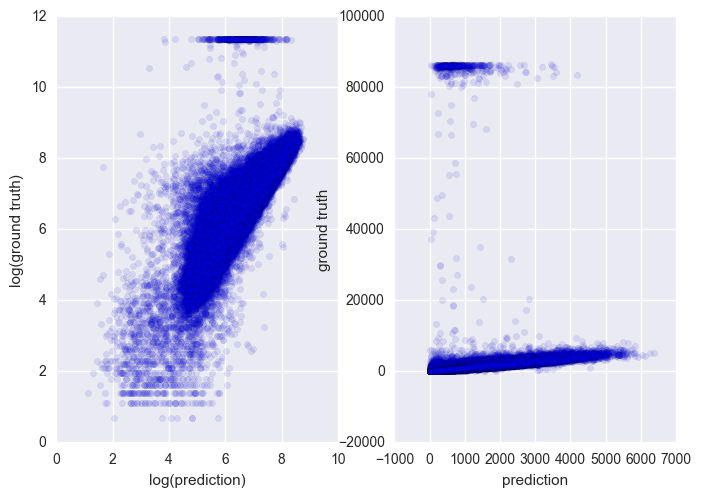

In [25]:
ypred = model.predict(dvalid)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

# XGB(Submission)
We need to transform back the log duration and save the submission file.

In [26]:
ytest = model.predict(dtest)
if test.shape[0] == ytest.shape[0]:
    print('Test shape OK.')
else:
    print('Oops')
test['trip_duration'] = np.exp(ytest)
test[['id', 'trip_duration']].to_csv('../output/beluga_xgb_submission.csv.gz', index=False, compression='gzip')

Test shape OK.


# LightGBM(Train Test)

In [36]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)

lgb_train = lgb.Dataset(Xtr, ytr)
lgb_eval = lgb.Dataset(Xv, yv, reference=lgb_train)

# Try different parameters! My favorite is random search :)
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l2_root'},
    'min_samples_leaf': 100,
    'learning_rate': 0.3,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'max_depth': 10,
    'verbose': 0,
    'lambda_l1': 1
}

# You could try to train with more epoch

gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50,
                verbose_eval=20)

# print('Modeling RMSLE %.5f' % gbm.best_score)
# t1 = dt.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

Train until valid scores didn't improve in 50 rounds.
[20]	valid_0's l2: 0.403024
[40]	valid_0's l2: 0.396186
[60]	valid_0's l2: 0.393977
[80]	valid_0's l2: 0.392802
[100]	valid_0's l2: 0.392258
[120]	valid_0's l2: 0.391545
[140]	valid_0's l2: 0.391163
[160]	valid_0's l2: 0.391335
[180]	valid_0's l2: 0.390969
[200]	valid_0's l2: 0.390969
[220]	valid_0's l2: 0.39109
[240]	valid_0's l2: 0.391074
Early stopping, best iteration is:
[193]	valid_0's l2: 0.390861


In [38]:
ytest = gbm.predict(test[feature_names].values, num_iteration=gbm.best_iteration)
test['trip_duration'] = np.exp(ytest)
test[['id', 'trip_duration']].to_csv('../output/beluga_lgb_submission.csv.gz', index=False, compression='gzip')